# Diffusion Equation / Heat Equation

In [98]:
# Imports
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim

## Solution
Our approach will be to first apply the advection numerical algorithm (created in earlier laboratories) and then add the diffusion on top of it.

Additionally, to model our selected problem we replace PsiAnalytic with the c(x, t) function which was implemented for the purposes of lab2.

In [99]:
def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i): 
        return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i): 
        return slice(i.start - self.sub, i.stop - self.sub)

In [100]:
nx = 128
X_LIMIT = 25
x, dx = np.linspace(0, X_LIMIT, nx+1, endpoint=True, retstep=True)
x = x[:-1] + dx/2
t_max = 40

one = shift(add=1, sub=1)
hlf = shift(add=0, sub=1)

nt = 600
dt = t_max / nt

i = slice(1, nx-1)
im = slice(1, nx)

## Problem & values
The problem we've decided to model is going to be a chemical spill in a narrow river. The chemical diffuses downstream while being carried by the river's flow.

- **M=5kg** - mass of substance
- **A=10m^2** - cross sectional area through which the substance is diffusing
- **D=0.01m^2/s** - diffusion coefficient, how quickly the substance is spreading
- **u=0.5m/s** - river's velocity

In [101]:
from scipy import constants


M = 5 # Mass
A = 10 # Cross sectional area
D = .01 # Diffusion coefficient
u = 0.5 # Advection coefficient
C_advection = u * dt / dx

def C(x,t):
    ans = np.zeros(len(x))

    ans = (M/A) * (1/(2*np.sqrt(constants.pi * D))) * (x/ t ** (3/2)) * np.exp(-(((u*t)-x)**2)/(4*D*t))
    ans += 0.001
    return ans

 

### Note
In the below loop, because the analytic solution c(x,t) involves division by **t**, the loop starts at *t=1*. Because of that, while looping over the generated plots we need to offset loops by the *step_offset*.

In [102]:
psi = C(x=x, t=1)
step_offset = int(nt / t_max)

C_diffusion = np.zeros(len(psi) - 1)
output = [psi.copy()]
for _ in range(step_offset,nt):
    # Apply diffusion
    C_diffusion[im - hlf] = -2 * D * dt / dx**2 * (psi[im] - psi[im - one]) / (psi[im - one] + psi[im])

    assert max(abs(C_diffusion)) <= 1 
    psi[i] = psi[i] - (
        F(psi[i      ], psi[i + one], C_diffusion[i + hlf]) -
        F(psi[i - one], psi[i      ], C_diffusion[i - hlf]) 
    )
    # Apply advection
    psi[i] = psi[i] - (
        F(psi[i    ], psi[i+one], C_advection) -
        F(psi[i-one], psi[i    ], C_advection) 
    )
    output += [psi.copy()]

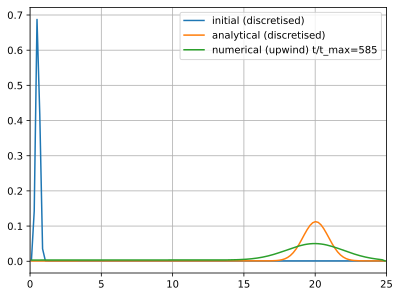

In [103]:
def plot(step):
    fig = pyplot.figure()

    pyplot.plot(x, C(x=x, t=1), label='initial (discretised)')
    pyplot.plot(x, C(x=x, t=step*dt+1), label='analytical (discretised)')
    pyplot.plot(x, output[step], label=f'numerical (upwind) t/t_max={step}')

    pyplot.legend()
    pyplot.grid()
    pyplot.xlim(0, X_LIMIT)
    # pyplot.ylim(0, 10)
    return fig 
plot(nt-step_offset)
show_plot('numeric.pdf')


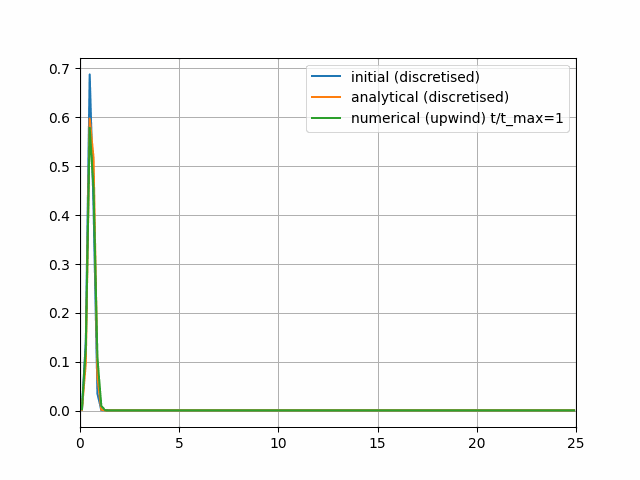

HTML(value="<a href='.\\anim_output.gif' target='_blank'>.\\anim_output.gif</a><br>")

In [104]:
show_anim(plot, range(1, nt-step_offset, 3), gif_file="anim_output.gif")

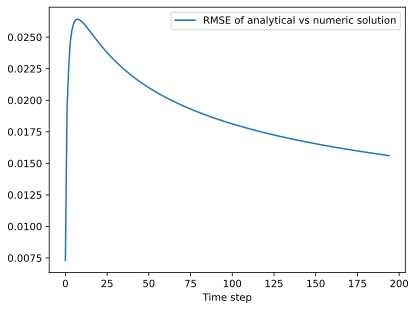

In [105]:
def RMSE(analytic, discrete):
    res = 0
    for i in range(0, len(discrete)):
        res += (analytic[i] - discrete[i]) ** 2
    
    res = np.sqrt(res/len(discrete))

    return res

rmse = []

for step in range(1, nt-step_offset, 3):
    rmse.append(RMSE(C(x=x, t=step*dt+1), output[step]))

pyplot.plot(rmse, label="RMSE of analytical vs numeric solution")
pyplot.xlabel("Time step")
pyplot.legend()

show_plot("rmse.pdf")


## Conclusions
As we can see in the plot over time, while the advection part of the simulation traces the analytical solution really well, the diffusion doesn't quite match between the two plots. Notably, the analytical solution seems to be substantially less sensitive to the value of **D**, which is the diffusion coefficient. Other limitations, such as the need to simulate starting from **t=1** might also contribute to the loss of accuracy.